In [151]:
##Import packages

import subprocess
import numpy as np
import os, sys, shutil
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import pandas as pd
import gc
import math
import time

from sklearn.cluster import KMeans

%matplotlib notebook

In [152]:
## Identify all water molecules
def distance(box, atom, aim_pool):
    vecs = abs(np.array(aim_pool, dtype='float')-np.array(atom, dtype='float'))
    for i in range(3):
        vecs[:,i] = np.minimum(vecs[:,i],box[i]-vecs[:,i])
    distance = np.linalg.norm(vecs,axis=1)
    return distance
def findNearest(box, atom, aim_pool, num):
    """
    Find the nearest one to given atom from a group of candidate
    Input: 
        box: periodic box size
        atom: given atom (position, dimention=3d)
        aim pool: a list of positions.
    Return:
        index of closest atom in aim_pool
    
    """
    vecs = abs(np.array(aim_pool, dtype='float')-np.array(atom, dtype='float'))
    for i in range(3):
        vecs[:,i] = np.minimum(vecs[:,i],box[i]-vecs[:,i])
    distance = np.linalg.norm(vecs,axis=1)
    sorted_dis = sorted(distance)
    res = np.where(distance <= sorted_dis[num])[0]
    if len(res)>num:
        res = np.concatenate((np.where(distance < sorted_dis[num])[0],np.where(distance == sorted_dis[num])[0]))
        res = res[:num]
    return res

In [153]:
### functions featuring h-bond.
def water_vec(water,box):
    o = np.array(water[0,1:],dtype='float')
    h1 = np.array(water[1,1:],dtype='float')
    h2 = np.array(water[2,1:],dtype='float')
    v1=h1-o
    v2=h2-o
    def __periodic(vec,box):
        for i,e in enumerate(vec):
            if abs(e)>box[i]/2:
                vec[i] = vec[i]-vec[i]/abs(vec[i])*box[i]
        return vec
    v1 = __periodic(v1,box)
    v2 = __periodic(v2,box)
    return (v1+v2)/(np.linalg.norm(v1+v2))
def interactionE(w1, w2, box):
    ##TIP3P water model
    ##Unit real
    charge = {'O':-0.834, 'H':0.417}
    eps = {'OO': 0.1521, 'HH': 0.0460, 'HO': 0.0836}
    sig = {'OO': 3.1507, 'HH': 0.4000, 'HO': 1.7753}
    def __c__(eles, dis):
        e = 1.60217662e-19
        k = 8.987551792314e9 #N meter_e2 Ce-2
        Na = 6.02214076e23
        res = Na*k*charge[eles[0]]*charge[eles[1]]*e**2/(dis*1e-10)/1000
        ##unit: kJ/mol
        #print(res)
        return res
    def __lj__(eles, dis):
        e = eps[eles]
        s = sig[eles]
        return 4*e*((s/dis)**12-(s/dis)**6)*4.184
    c = 0
    lj=0
    for e1 in w1:
        for e2 in w2:
            dis = distance(box, e1[1:], [e2[1:]])[0]
            eles = ''.join(sorted(e1[0]+e2[0]))
            c+=__c__(eles, dis)
            lj+=__lj__(eles, dis)
    return c+lj
def OH_O_ang(w1, w2, box):
    def __periodic(vec,box):
        for i,e in enumerate(vec):
            if abs(e)>box[i]/2:
                vec[i] = vec[i]-vec[i]/abs(vec[i])*box[i]
        return vec
    o1 = np.array(w1[0,1:],dtype='float')
    h1_1 = np.array(w1[1,1:],dtype='float')
    h1_2 = np.array(w1[2,1:],dtype='float')
    o2 = np.array(w2[0,1:],dtype='float')
    h2_1 = np.array(w2[1,1:],dtype='float')
    h2_2 = np.array(w2[2,1:],dtype='float')
    #print([h1_1, h1_2],findNearest(box, o2, [h1_1, h1_2], 1))
    H = [h1_1, h1_2][findNearest(box, o2, [h1_1, h1_2], 1)[0]]
    HO = __periodic(o1-H,box)
    HO = HO/np.linalg.norm(HO)
    H_O = __periodic(o2-H,box)
    H_O = H_O/np.linalg.norm(H_O)
    temp = np.dot(HO, H_O)
    if temp>1:
        temp=1
    if temp<-1:
        temp=-1
    return math.acos(temp)
def H_OH_ang(w1, w2, box):
    def __periodic(vec,box):
        for i,e in enumerate(vec):
            if abs(e)>box[i]/2:
                vec[i] = vec[i]-vec[i]/abs(vec[i])*box[i]
        return vec
    o1 = np.array(w1[0,1:],dtype='float')
    h1_1 = np.array(w1[1,1:],dtype='float')
    h1_2 = np.array(w1[2,1:],dtype='float')
    o2 = np.array(w2[0,1:],dtype='float')
    h2_1 = np.array(w2[1,1:],dtype='float')
    h2_2 = np.array(w2[2,1:],dtype='float')
    H = [h1_1, h1_2][findNearest(box, o2, [h1_1, h1_2], 1)[0]]
    O_H = __periodic(H-o2,box)
    O_H = O_H/np.linalg.norm(O_H)
    OH1 = __periodic(h2_1-o2,box)
    OH1 = OH1/np.linalg.norm(OH1)
    OH2 = __periodic(h2_2-o2,box)
    OH2 = OH2/np.linalg.norm(OH2)
    t1 = np.dot(O_H, OH1)
    t2 = np.dot(O_H, OH2)
    if t1>1:
        t1=1
    if t1<-1:
        t1=-1
    if t2>1:
        t2=1
    if t2<-1:
        t2=-1
    return min([math.acos(t1), math.acos(t2)], key=abs)
def HOO_ang(w1, w2, box):
    def __periodic(vec,box):
        for i,e in enumerate(vec):
            if abs(e)>box[i]/2:
                vec[i] = vec[i]-vec[i]/abs(vec[i])*box[i]
        return vec
    o1 = np.array(w1[0,1:],dtype='float')
    h1_1 = np.array(w1[1,1:],dtype='float')
    h1_2 = np.array(w1[2,1:],dtype='float')
    o2 = np.array(w2[0,1:],dtype='float')
    h2_1 = np.array(w2[1,1:],dtype='float')
    h2_2 = np.array(w2[2,1:],dtype='float')
    H = [h1_1, h1_2][findNearest(box, o2, [h1_1, h1_2], 1)[0]]
    O_H = __periodic(H-o1,box)
    O_H = O_H/np.linalg.norm(O_H)
    O_O = __periodic(o2-o1,box)
    O_O = O_O/np.linalg.norm(O_O)
    t1 = np.dot(O_H, O_O)
    if t1>1:
        t1=1
    if t1<-1:
        t1=-1
    return math.acos(t1)
def H_bondL(w1, w2, box):
    def __periodic(vec,box):
        for i,e in enumerate(vec):
            if abs(e)>box[i]/2:
                vec[i] = vec[i]-vec[i]/abs(vec[i])*box[i]
        return vec
    o1 = np.array(w1[0,1:],dtype='float')
    h1_1 = np.array(w1[1,1:],dtype='float')
    h1_2 = np.array(w1[2,1:],dtype='float')
    o2 = np.array(w2[0,1:],dtype='float')
    h2_1 = np.array(w2[1,1:],dtype='float')
    h2_2 = np.array(w2[2,1:],dtype='float')
    H = [h1_1, h1_2][findNearest(box, o2, [h1_1, h1_2], 1)[0]]
    return np.linalg.norm(__periodic(H-o2,box))

In [154]:
## Identify Hydrogen Bond by energy and geometry

### defination of H bond
### OH_O bond ang >100 degree
### H_OH bond ang >70 degree
### interaction energy < -9.4kJ/mol
### OO distance <= 3.8
def id_Hbond(w1, w2, box):
    ## from w1(donar) to w2(acceptor) ( H bond by H from w1 and O from w2)
    """
    w1: array, [['O', Ox, Oy, Oz],['H', Hx, Hy, Hz],['H', Hx, Hy, Hz]]
    w1: array, [['O', Ox, Oy, Oz],['H', Hx, Hy, Hz],['H', Hx, Hy, Hz]]
    """
    #sol0: OO distance
    sol0 = distance(box, w1[0,1:], [w2[0,1:]])[0] <= 6
    #sol1: OH-O angle 
    sol1 = OH_O_ang(w1, w2, box) > math.pi/180.0*100
    #sol2: minimum of the two H-OH angle
    sol2 = H_OH_ang(w1, w2, box)>math.pi/180.0*70
    #sol3: interaction energy**
    sol3 = interactionE(w1, w2, box)<-3.6
    #sol4: backward OH-O angle
    sol4 = OH_O_ang(w2, w1, box) < math.pi/180.0*100
    #sol5: HO-O angle
    sol5 = HOO_ang(w1, w2, box) < math.pi/180.0*45
    #sol6: backward HO-O angle
    sol6 = HOO_ang(w2, w1, box) > math.pi/180.0*20
    #sol7: H---O distance
    return sol3&sol5&sol0#&sol5&sol6 & sol0 & sol1 & sol2 & sol3

In [155]:
def build_Hbond_mat(water_mols, box):
    mol_num = len(water_mols)
    res = np.zeros((mol_num, mol_num))
    for i in range(mol_num):
        for j in range(mol_num):
            if id_Hbond(water_mols[i], water_mols[j], box):
                res[i,j] = 1
                res[j,i] = -1
    return res
def Hbond_pairs(water_mols, box):
    res = []
    mol_num = len(water_mols)
    temp_mat = build_Hbond_mat(water_mols, box)
    for i in range(mol_num):
        for j in range(mol_num):
            if temp_mat[i,j] == 1:
                res.append([i,j])
    return np.array(res)
def show_water_net(water_mols, box, pairs=False):
    
    def mapping(orig_pts, box):
        new_pts = np.array(orig_pts)
        new_pts = np.concatenate((new_pts-[box[0],0,0,0], new_pts, new_pts+[box[0],0,0,0]),axis = 0)
        new_pts = np.concatenate((new_pts-[0,box[1],0,0], new_pts, new_pts+[0,box[1],0,0]),axis = 0)
        new_pts = np.concatenate((new_pts-[0,0,box[2],0], new_pts, new_pts+[0,0,box[2],0]),axis = 0)
        return new_pts
    def if_inArea(pos, area):
        res = True
        for p,a in zip(pos, area):
            res = res and ((p <= a[1]) & (p>=a[0]))
        return res
    
    def __periodic(vec,box):
        for i,e in enumerate(vec):
            if abs(e)>box[i]/2:
                vec[i] = vec[i]-vec[i]/abs(vec[i])*box[i]
        return vec
    
    if type(pairs)==bool:
        pairs = build_Hbond_mat(water_mols, box)
    points = np.c_[np.array(water_mols[:,0,1:],dtype = 'float'),np.arange(0,len(water_mols))]
    points = mapping(points, box)
    l_range = np.c_[np.zeros(3)-4,box+4]
    inrange_idx=[]
    for idx, O_pos in enumerate(points):
        if if_inArea(O_pos[:3], l_range):
            inrange_idx.append(idx)
    
    points = np.array(sorted(points[inrange_idx],key = lambda x:x[-1]))

    
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    xx, yy, zz = np.meshgrid([0,box[0]],
                [0,box[1]],
                [0,box[2]])
    ax.voxels(xx,yy,zz,np.ones(xx.shape)[:-1,:-1,:-1],facecolors=np.array([[[(0., 0., 0., 0.)]]]),edgecolors='k')

    
    ax.scatter(points[:,0],points[:,1],points[:,2],color='red',alpha=0.7)
    
    for p in pairs:
        _from = np.array([pt[:3] for pt in points if pt[-1] == p[0]])
        _vec = __periodic(water_mols[p[1],0,1:]-water_mols[p[0],0,1:],box)
        #print(np.linalg.norm(_vec))
        _vec = np.array([_vec]*len(_from))
        ax.quiver(_from[:,0],_from[:,1],_from[:,2],_vec[:,0],_vec[:,1],_vec[:,2],\
                  linewidths=1,arrow_length_ratio=0.3)
    
    max_range = np.array([points[:,0].max()-points[:,0].min(), points[:,1].max()-points[:,1].min(), points[:,2].max()-points[:,2].min()]).max() / 2.0

    mid_x = (points[:,0].max()+points[:,0].min()) * 0.5
    mid_y = (points[:,1].max()+points[:,1].min()) * 0.5
    mid_z = (points[:,2].max()+points[:,2].min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    ax.axis('off')
    plt.show()
    
    return

In [156]:
## show 2 water molecules (3D):
from mpl_toolkits.mplot3d import Axes3D
def print_mol(w1, w2,box):
    ### red: H bond donor
    def __periodic(vec,box):
        for i,e in enumerate(vec):
            if abs(e)>box[i]/2:
                vec[i] = vec[i]-vec[i]/abs(vec[i])*box[i]
        return vec
    o1 = np.array(w1[0,1:],dtype='float')
    h1_1 = np.array(w1[1,1:],dtype='float')
    h1_2 = np.array(w1[2,1:],dtype='float')
    oh1_1 = __periodic(h1_1-o1,box)
    oh1_2 = __periodic(h1_2-o1,box)
    o2 = np.array(w2[0,1:],dtype='float')
    h2_1 = np.array(w2[1,1:],dtype='float')
    h2_2 = np.array(w2[2,1:],dtype='float')
    oh2_1 = __periodic(h2_1-o2,box)
    oh2_2 = __periodic(h2_2-o2,box)
    h2_1 = o2+oh2_1
    h2_2 = o2+oh2_2
    oo = __periodic(o2-o1,box)
    displace= oo - (o2-o1)
    o2 = o2+displace
    h2_1 = h2_1+displace
    h2_2 = h2_2+displace
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ps = np.array([o1, o2, h1_1, h1_2, h2_1, h2_2])
    ps[:,0] = ps[:,0] - ps[:,0].min()
    ps[:,1] = ps[:,1] - ps[:,1].min()
    ps[:,2] = ps[:,2] - ps[:,2].min()
    
    ax.scatter(ps[:1,0],ps[:1,1],ps[:1,2],color='red',alpha=1,s=1000)
    ax.scatter(ps[1:2,0],ps[1:2,1],ps[1:2,2],color='pink',alpha=1,s=1000)
    ax.scatter(ps[2:,0],ps[2:,1],ps[2:,2],color='blue',alpha=1,s=800)
    
    X, Y, Z = [ps[:1,0]],[ps[:1,1]],[ps[:1,2]]
    U, V, W = [oo[0]],[oo[1]],[oo[2]]
    ax.quiver(X,Y,Z,U,V,W,)
    
    max_range = np.array([ps[:,0].max()-ps[:,0].min(), ps[:,1].max()-ps[:,1].min(), ps[:,2].max()-ps[:,2].min()]).max() / 2.0

    mid_x = (ps[:,0].max()+ps[:,0].min()) * 0.5
    mid_y = (ps[:,1].max()+ps[:,1].min()) * 0.5
    mid_z = (ps[:,2].max()+ps[:,2].min()) * 0.5
    ax.set_xlim(mid_x - max_range-2, mid_x + max_range+2)
    ax.set_ylim(mid_y - max_range-2, mid_y + max_range+2)
    ax.set_zlim(mid_z - max_range-2, mid_z + max_range+2)
    print('red: H bond donor')
    ax.axis('off')
    plt.show()

In [157]:
'''
def findPath(pairs, start):
    pairs = np.array(pairs)
    paths = [[start]]
    ends=[[start]]
    _j = True
    while _j:
        for i, _s in enumerate(ends):
            if _s == False:
                continue
            if _s not in path[:,0]:
                ends[_i] = 
'''
def adjacency_Mat(water_mols, box, no_dir = False):
    mol_num = len(water_mols)
    res = np.zeros((mol_num, mol_num))
    for i in range(mol_num):
        for j in range(mol_num):
            #print(i,j)
            if id_Hbond(water_mols[i], water_mols[j], box):
                res[i,j] = 1
                if no_dir:
                    res[j,i] = 1
    return res

In [158]:
### Distance Mat
def ini_d_mat(mol_num, adj_mat):
    res = np.array([[float('inf')]*mol_num]*mol_num)
    for i in range(mol_num):
        for j in range(mol_num):
            
            if i==j:
                res[i,j] = 0
            if adj_mat[i,j]==1:
                res[i,j]=1
    return res
def Floyd(d_mat):
    for k in range(len(d_mat)):
        for i in range(len(d_mat)):
            for j in range(len(d_mat)):
                d_mat[i,j] = min([d_mat[i,j], d_mat[i,k]+d_mat[k,j]])
    return d_mat

In [159]:
## Example structure
#### read structure
#data_path = '/bigdata/greaneylab/wzhan097/whoochul'
data_path = '/rhome/wzhan097/shared/H3PO4_XDATCAR/RT_last_run'
filename = 'XDATCAR'
with open(os.path.join(data_path,filename),'r') as f:
    lines = f.readlines()
    
box = lines[2:5]
box =[e.split() for e in box]
box = [box[0][0],box[1][1],box[2][2]]
box = [float(e) for e in box]
lines = lines[5:]
types = lines[0].split()
temp = lines[1].split()
temp = [int(e) for e in temp]
eles = []
atom_num = sum(temp)

for _i,_j in zip(types, temp):
    eles = eles+[[_i]]*_j
eles = np.array(eles, dtype = 'object')
lines = lines[2:]
atom_num, eles, box

(306, array([['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
        ['O'],
     

In [56]:
len(lines)/(atom_num+1)

3800.0

In [10]:
def get_OH(atoms_lines, box):
    
    pos = [[float(_e) for _e in e.split()] for e in atoms_lines[1:]]
    pos = np.array(pos, dtype = 'object')
    atoms = np.concatenate((eles, pos),axis=1)
    for i in range(len(box)):
        atoms[:,i+1] = atoms[:,i+1]*box[i]
    
    Os = atoms[np.where(atoms[:,0]=='O')[0],1:]
    Hs = atoms[np.where(atoms[:,0]=='H')[0],1:]

    dis_mat = np.zeros((len(Hs), len(Os)))
    for i in range(len(Hs)):
        dis_mat[i] = distance(box, Hs[i], Os)
    dis = np.array([min(e) for e in dis_mat])
    return dis

In [11]:
dis_mat = np.zeros((int(len(lines)/(atom_num+1)),len(np.where(eles=='H')[0])))
dis_mat.shape

(3800, 162)

In [12]:
for i in range(int(len(lines)/(atom_num+1))):
    temp = get_OH(lines[i*(atom_num+1):(i+1)*(atom_num+1)],box)
    dis_mat[i] = temp
    if i%100 == 0:
        print(i)

0
100
200
300
400
500


KeyboardInterrupt: 

In [60]:
outfile = "RT_last_run_OH.npy"
np.save(outfile,dis_mat)

In [13]:
outfile = "LowT_last_run_OH.npy"
x = np.load(outfile)

In [14]:
lines = ['\t'.join(list(map(str,e)))+'\n' for e in x]
lines
with open('LowT_last_run_OH'+'.tsv','w+') as f:
    f.writelines(lines)

In [ ]:
#Direct
'''
for _i,_j in zip(types, temp):
    eles = eles+[[_i]]*_j
lines = lines[3:3+atom_num]
pos = [[float(_e) for _e in e.split()] for e in lines]
eles = np.array(eles, dtype = 'object')
pos = np.array(pos, dtype = 'object')
atoms = np.concatenate((eles, pos),axis=1)
for i in range(len(box)):
    atoms[:,i+1] = atoms[:,i+1]*box[i]
atoms
'''

In [160]:
#_OHO_all, OHO_flg, _OH_all, _OH_flg
filename = 'LowT_last_run_OH'+'_all'+'.npy'
rt_OH = np.load(filename)
filename = 'LowT_last_run_OH'+'_flg'+'.npy'
rt_OH_flg = np.load(filename)

filename = 'LowT_last_run'+'_Oinds_Hinds_all'+'.npy'
rt_OH_inds = np.load(filename)

In [169]:
np.where(rt_OH_flg[181:7323,20]==0)

(array([   9,   10,   11, ..., 7133, 7134, 7135]),)

<IPython.core.display.Javascript object>


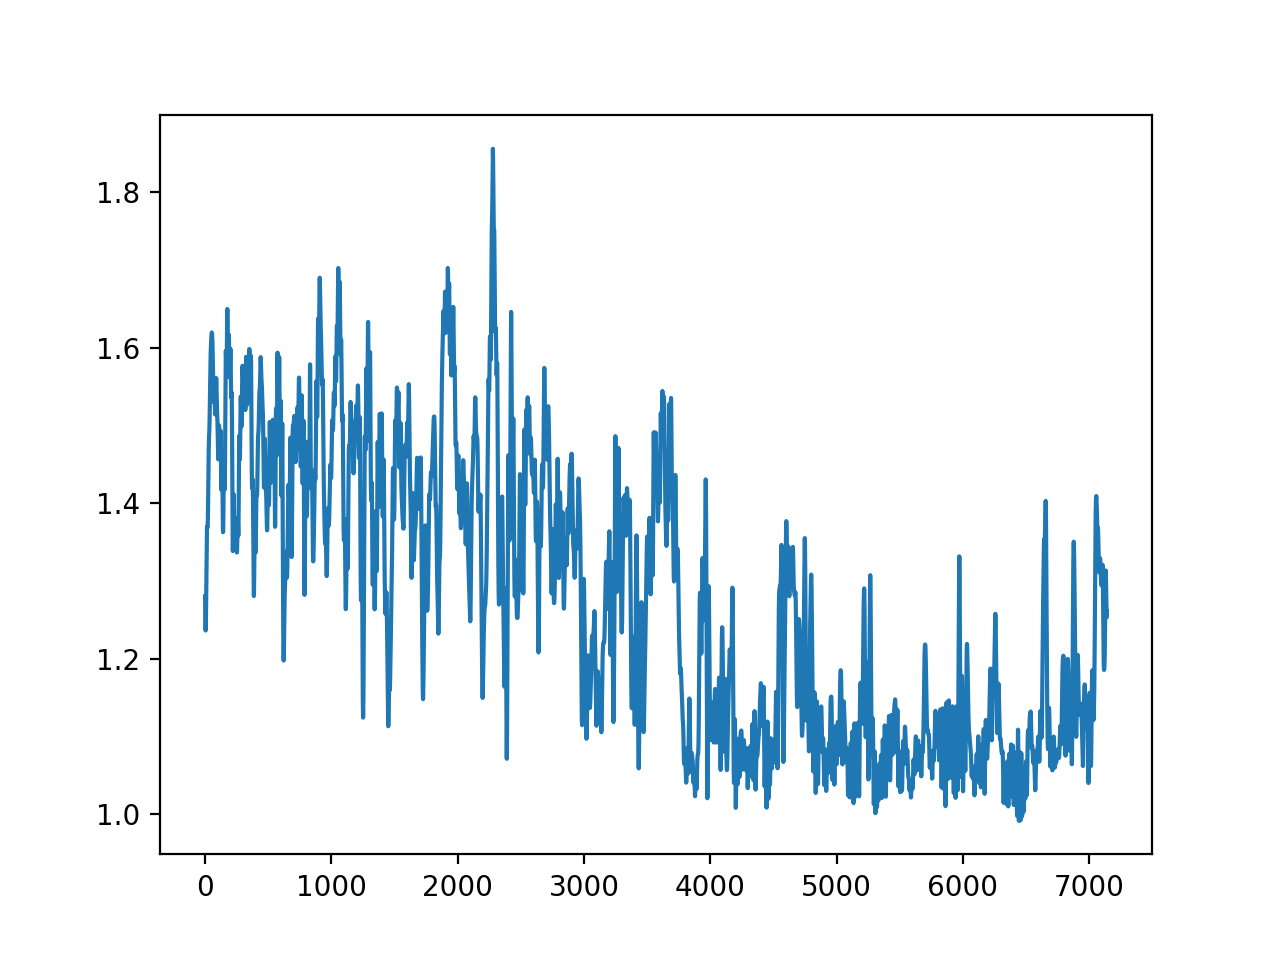

In [168]:
plt.plot(rt_OH[181:7323,20])

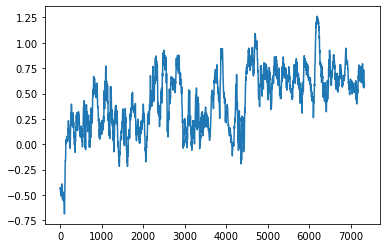

In [150]:
bond_a = rt_OH[:,54]
bond_b = rt_OH[:,55]
bond_ave = (bond_a+bond_b)/2
bond_diff = (bond_a-bond_b)
plt.plot(bond_diff)

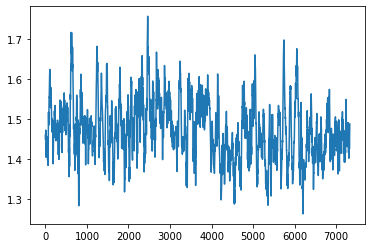

In [145]:
plt.plot(bond_ave)

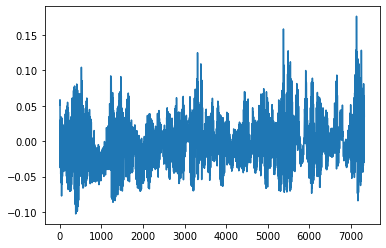

In [22]:
temp_data = rt_OH[:,6]
mu = np.average(temp_data)
rela_data = temp_data-mu
plt.plot(rela_data)

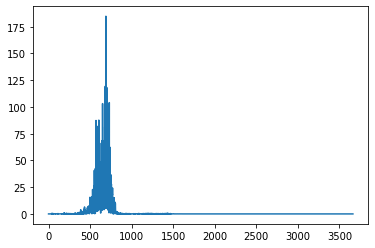

In [128]:
temp_data=rt_OH[:,6]
vel = temp_data[1:]-temp_data[:-1]
fft = np.fft.fft(vel)
ps = fft*np.conjugate(fft)
acf = np.fft.ifft(ps)
plt.plot(ps[:int(len(ps)/2)])

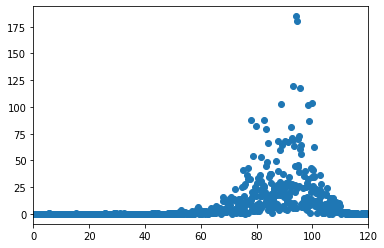

In [129]:
signal = vel
fourier = np.fft.fft(signal)
n = signal.size
timestep = 1E-3
freq = np.fft.fftfreq(n, d=timestep)

plt.scatter(freq,ps)
plt.xlim(0,120)
plt.show()

In [114]:
signal[idx-np.ceil(moving_win/2):idx+np.floor(moving_win/2)]

numpy.ndarray

In [113]:
'''
moving_win = 5
smt_data = np.zeros(np.shape(signal-moving_win))
for i,_ in enumerate(smt_data):
    idx = i+np.ceil(moving_win/2)
    print(signal[idx-np.ceil(moving_win/2):idx+np.floor(moving_win/2)])
    if i>10:
        break
    #smt_data[i] = np.average(signal[idx-np.ceil(moving_win/2):idx+np.floor(moving_win/2)])
smt_data
'''

TypeError: slice indices must be integers or None or have an __index__ method

In [127]:
import scipy
sml_signal = scipy.stats.gaussian_kde(ps)
plt_freq = np.arange(0,120,0.1)
plt.plot(plt_freq,sml_signal(plt_freq))

UFuncTypeError: Cannot cast ufunc 'add' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

In [ ]:
#TODO:width of peaks v.s. lifetime
#decompose two bond-length average of the two, difference of the two
#Continue-PB -> moving on to RAPTOR maybe
#Adjacency Matrix on LT&RT

In [170]:
time = np.arange(len(temp_data)) #unit:fs
period_cos = 10 #0.01ps 
test_cos = np.cos(time/period_cos * 2*np.pi)
tau = 20
decay = np.exp(-time/tau)

period_2 = 12
period_2_factor = 0.5*np.cos(time/period_2 * 2*np.pi)
tau_2 = 20
decay_2 = np.exp(-time/tau_2)
factor_data = period_2_factor*decay_2

plt.plot((decay*test_cos)[:100])

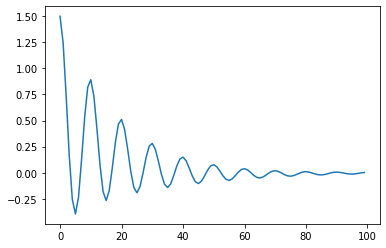

In [101]:
plt.plot((factor_data+cos_test_data)[:100])

In [173]:
temp_data_with_factor = factor_data+cos_test_data

temp_data_with_factor = temp_data_with_factor[1:] - temp_data_with_factor[:-1]

fft = np.fft.fft(temp_data_with_factor)
ps = fft*np.conjugate(fft)

signal = temp_data_with_factor
fourier = np.fft.fft(signal)
n = signal.size
timestep = 1E-3
freq = np.fft.fftfreq(n, d=timestep)

plt.scatter(freq,ps)
plt.xlim(0,120)
plt.savefig('temp.png')

In [172]:
plt.plot(acf)

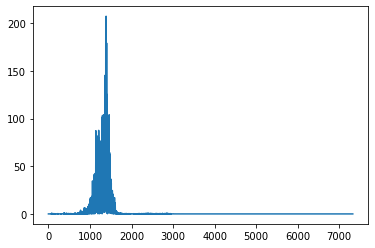

In [39]:
extended_vel = np.concatenate((vel,np.zeros(vel.shape)))
fft = np.fft.fft(extended_vel)
ps = fft*np.conjugate(fft)
acf = np.fft.ifft(ps)
plt.plot(ps[:int(len(ps)/2)])

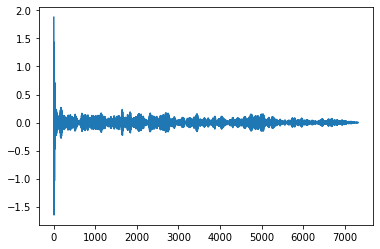

In [40]:
plt.plot(acf[:int(len(acf)/2)])

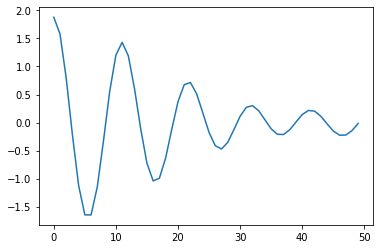

In [41]:
plt.plot(acf[:50])

In [25]:
def R_k(rlist, k):
    l=len(rlist)
    working_l = np.concatenate((rlist,rlist[:k]))
    mu = np.average(working_l) # average 
    s = np.std(working_l,ddof=1) # 
    working_l = (working_l-mu)/s
    res = 0
    for i in range(l-k):
        res+=working_l[i]*working_l[i+k]
    res = res/l
    return res

In [19]:
def ACF_FFT(t_max, J):
    # Compute the autocorrelation of the instantaniouse flux vector 
    nd = len(J)
    time_intervals = nd
    c = np.zeros([3,time_intervals*2])
    zpad = np.zeros(time_intervals)
    sf = t_max/float(time_intervals)
    dft  = np.fft.fft(np.concatenate((J,zpad)))
    c = np.fft.ifft(dft*np.conjugate(dft))*sf
    return c[:time_intervals]

In [20]:
temp = ACF_FFT(20,np.array(rt_OH[:,6]))

In [21]:
from scipy.fftpack import fft, dct
dct(temp)

array([ 1.51632650e+05+4.86533636e-12j,  6.14186900e+04+9.45664045e-13j,
        2.38933414e+00-1.53291379e-12j, ...,
        1.04300943e-06+9.85870022e-14j, -2.35333086e-06-4.02728020e-13j,
        3.49515176e-07+7.39539000e-13j])

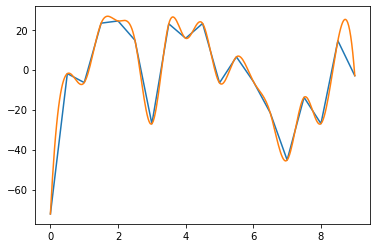

'\nfreq = 0\nfor i in range(1,len(l_smooth)-1):\n    if l_smooth[i-1]<=l_smooth[i] and l_smooth[i+1]<=l_smooth[i]:\n        if knew[i] >= 2:\n            freq = knew[i]\n            break\nif freq == 0:\n    return 0, np.average(rlist)\nreturn np.sqrt(17/9)/freq, np.average(rlist)\nplt.scatter(range(1,20,1),[1:20])\n'

In [48]:
from scipy.interpolate import make_interp_spline, BSpline
temp = dct(rt_OH[:,6])[1:20]

ks = np.arange(len(temp))
ks = ks*0.5
    
knew = np.linspace(ks.min(), ks.max(), 300) 
spl = make_interp_spline(ks, temp, k=3)
l_smooth = spl(knew)

plt.plot(ks, temp)
plt.plot(knew, l_smooth)
plt.show()
'''
freq = 0
for i in range(1,len(l_smooth)-1):
    if l_smooth[i-1]<=l_smooth[i] and l_smooth[i+1]<=l_smooth[i]:
        if knew[i] >= 2:
            freq = knew[i]
            break
if freq == 0:
    return 0, np.average(rlist)
return np.sqrt(17/9)/freq, np.average(rlist)
plt.scatter(range(1,20,1),[1:20])
'''

In [33]:
len(dct(temp))

7328

In [21]:
l = []
for k in ks:
    l.append(R_k(rt_OH[:,6],k))
#spline with 3rd-order
plt.plot(l[5:])

NameError: name 'ks' is not defined

In [22]:
l = []
for k in ks:
    l.append(R_k(rt_OH[:,76],k))
plt.plot(l)

NameError: name 'ks' is not defined

In [52]:
rt_OH_flg[:,76]

array([1., 1., 1., ..., 1., 1., 1.])

In [1]:
periods = []
for i in range(len(rt_OH[0])):
    l = rt_OH_flg[:,i]
    _start=0
    _end = 0
    _if = 0
    _periods = []
    for _i, e in enumerate(l):
        if e == 1:
            if _if == 0:
                _start = _i
                _if=1
            if _if == 1:
                _end = _i
        if e == 0:
            if _if == 1:
                _period = _end - _start
                _if=0
                if _period > 50:
                    _periods.append([_start,_end])
        #print(_start,_end,_if,e)
    if _if == 1:
        _period = _end - _start
        if _period > 50:
            _periods.append([_start,_end])
    print(i,_periods)
    periods.append(_periods)
periods

NameError: name 'rt_OH' is not defined